<a href="https://colab.research.google.com/github/sjeena0722/3-min-pytorch/blob/main/cGAN%EC%9C%BC%EB%A1%9C_%EC%83%9D%EC%84%B1_%EC%A0%9C%EC%96%B4%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 하이퍼파라미터
EPOCHS = 300
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [3]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



In [4]:
# 생성자 (Generator)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        c = self.embed(labels)
        x = torch.cat([z, c], 1)
        return self.model(x)

In [5]:
# 판별자 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        c = self.embed(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)

In [6]:
# 모델 인스턴스를 만들고 모델의 가중치를 지정한 장치로 보내기
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

# 이진 교차 엔트로피 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr =0.0002)
g_optimizer = optim.Adam(G.parameters(), lr =0.0002)

In [7]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)

        # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산 (데이터셋 레이블 입력)
        labels = labels.to(DEVICE)
        outputs = D(images, labels)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
    
        # 무작위 텐서와 무작위 레이블을 생성자에 입력해 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 100).to(DEVICE)
        g_label = torch.randint(0, 10, (BATCH_SIZE,)).to(DEVICE)
        fake_images = G(z, g_label)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
        outputs = D(fake_images, g_label)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake
        
        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차 계산(무작위 레이블 입력)
        fake_images = G(z, g_label)
        outputs = D(fake_images, g_label)
        g_loss = criterion(outputs, real_labels)

        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    print('이폭 [{}/{}] d_loss:{:.4f} g_loss: {:.4f} D(x):{:.2f} D(G(z)):{:.2f}'
          .format(epoch,
                  EPOCHS,
                  d_loss.item(),
                  g_loss.item(),
                  real_score.mean().item(),
                  fake_score.mean().item()))

이폭 [0/300] d_loss:0.1936 g_loss: 4.4373 D(x):0.94 D(G(z)):0.09
이폭 [1/300] d_loss:1.2854 g_loss: 3.5964 D(x):0.67 D(G(z)):0.30
이폭 [2/300] d_loss:0.5917 g_loss: 4.0386 D(x):0.83 D(G(z)):0.19
이폭 [3/300] d_loss:0.5597 g_loss: 3.3718 D(x):0.85 D(G(z)):0.16
이폭 [4/300] d_loss:0.4928 g_loss: 3.1001 D(x):0.92 D(G(z)):0.23
이폭 [5/300] d_loss:0.4160 g_loss: 2.8967 D(x):0.92 D(G(z)):0.22
이폭 [6/300] d_loss:0.6660 g_loss: 1.9492 D(x):0.79 D(G(z)):0.22
이폭 [7/300] d_loss:0.7323 g_loss: 2.0054 D(x):0.79 D(G(z)):0.25
이폭 [8/300] d_loss:1.0764 g_loss: 1.5886 D(x):0.63 D(G(z)):0.27
이폭 [9/300] d_loss:1.0625 g_loss: 1.7176 D(x):0.69 D(G(z)):0.31
이폭 [10/300] d_loss:0.7915 g_loss: 1.5553 D(x):0.78 D(G(z)):0.31
이폭 [11/300] d_loss:1.1733 g_loss: 1.5785 D(x):0.59 D(G(z)):0.31
이폭 [12/300] d_loss:1.1690 g_loss: 1.7269 D(x):0.63 D(G(z)):0.30
이폭 [13/300] d_loss:0.9615 g_loss: 1.4220 D(x):0.69 D(G(z)):0.32
이폭 [14/300] d_loss:0.9503 g_loss: 1.4830 D(x):0.72 D(G(z)):0.34
이폭 [15/300] d_loss:0.9518 g_loss: 1.5904 D(x):0.66

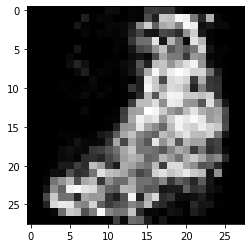

In [8]:
# 만들고 싶은 아이템 생성하고 시각화하기
item_number = 9 # 아이템 번호
z = torch.randn(1, 100).to(DEVICE) # 배치 크기 1
g_label = torch.full((1,), item_number, dtype=torch.long).to(DEVICE)
sample_images = G(z, g_label)

sample_images_img = np.reshape(sample_images.data.cpu().numpy()
                               [0],(28, 28))
plt.imshow(sample_images_img, cmap = 'gray')
plt.show()